In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

from datetime import datetime, timezone

In [37]:
def get_timings(p):    
    m,b = np.polyfit([p[0,1],p[-1,1]], [0, p[-1,2]-p[0,2]], deg=1)

    timings = lambda x: 1e-9 * (m * x + b)  # seconds
    return timings

### SQL settings

In [2]:
DBNAME = "fesa_test"
HOST = "140.181.85.66"
PORT = "54321"
USER = "fesa_tester"
PASSWORD = "save_bpm"

In [3]:
try:
    dbcon = psycopg2.connect("dbname="+DBNAME + " user=" + USER + " host=" + HOST + " port=" + PORT + " password=" + PASSWORD)
except Exception as e:
    print("Unable to connect to database")
    print(e)

crsr = dbcon.cursor()

### Sequence start

In [4]:
def stamp2time(stamp):
    ts = stamp / 1e9
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f')

In [5]:
def fetch_sequenceStartStamp(crsr=crsr):
    stamps = crsr.execute("SELECT sequenceStartStamp FROM dcct;")
    
    return crsr.fetchall()

In [6]:
stamps = fetch_sequenceStartStamp()
first_record = stamps[0][0]
last_record = stamps[-1][0]

stamp2time(last_record)

'2023-10-18 13:38:11.259820'

# Read DCCT

In [7]:
date = "2023-10-18"
time = "13:38:04.0"

In [8]:
time_datetime = datetime.strptime(" ".join([date,time]), '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc)
stamp_given = int(time_datetime.timestamp() * 1e9)

stamps_arr = np.array(stamps).squeeze(axis=1)
idx_closest_stamp = np.abs(stamps_arr - stamp_given).argmin()

###### fetch

In [9]:
display_stamp = stamps_arr[idx_closest_stamp]

crsr.execute("SELECT processIndex, intensity, processStartStamp FROM dcct WHERE sequenceStartStamp = %s;", [int(display_stamp)])
data = crsr.fetchall()

In [41]:
dcct_intensity = list()
processIndices = list()
for pid, intensity, t in data:
    processIndices.append([pid, len(dcct_intensity), t])
        
    dcct_intensity += intensity
    
processIndices = np.array(processIndices)
timing = get_timings(processIndices)

###### plot

Text(0, 0.5, 'intensity [particles]')

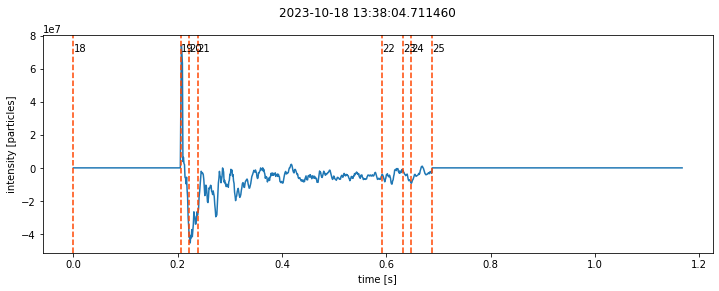

In [51]:
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle(stamp2time(display_stamp))

ax.plot(timing(np.arange(len(dcct_intensity))), dcct_intensity)

for pid, loc, _ in processIndices:
    ax.axvline(timing(loc),
          linestyle="dashed", color="orangered")
    
    ax.text(timing(loc), 0.95*max(dcct_intensity), str(pid))
    
# make nice
ax.set_xlabel("time [s]")
ax.set_ylabel("intensity [particles]")

# debug